In [10]:
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime

In [11]:
dataframes = pd.DataFrame(columns=['year', 'simulation', 'region', 'PRECT'])

def process_region(data, region, lat_slice, lon_slice):
    # Weight and average for the specified region
    ds_region = data.sel(lat=lat_slice, lon=lon_slice)
    weights_region = np.cos(np.deg2rad(ds_region['lat']))
    weights_region.name = 'weights'
    ds_weighted_region = ds_region['PRECT'].weighted(weights_region)
    mean_sst_region = ds_weighted_region.mean(dim=['lat', 'lon'])
    ds_region = mean_sst_region

    # Filter months of interest (Nov, Dec, Jan, Feb, Mar)
    month_list = [True if month in [11, 12, 1, 2, 3] else False for month in data['time.month']]
    ds_region = ds_region.loc[{'time': month_list}] 

    # Create a new variable for grouping Nov, Dec and Jan, Feb, March from the following year
    # e.g. Nov, Dec 1940 and Jan, Feb, March 1941 -> 1940
    ds_region['year_group'] = (
        ds_region['time.year'] + (ds_region['time.month'] >= 11) - 1
    ).astype(str)

    # Calculate sum PRECT for each year
    ds_region = ds_region.groupby('year_group').sum(dim='time')

    # Convert m/s to mm/day (1 m/s = 86400000 mm/day)
    ds_region = ds_region * 86400000

    # Append to the DataFrame
    df = pd.DataFrame({
        'year': ds_region.coords['year_group'].values,
        'simulation': data.attrs['case'][-8:],
        'region': region,
        'PRECT': ds_region.values
    })

    return df

def calc_prect(PRECT_data_fn):

    global dataframes
    
    ds = xr.open_dataset(PRECT_data_fn, decode_times=False)

    reference_date = pd.to_datetime("1850-01-01")
    start_date = reference_date + datetime.timedelta(days = float(ds.time[0]))

    ds['time'] = pd.date_range(start=start_date, periods=ds.sizes['time'], freq='MS')

    south_df = process_region(ds, 'South', slice(32.0, 34.9), slice(239.4, 245.6))
    central_df = process_region(ds, 'Central', slice(34.9, 38.6), slice(236.9, 243.1))
    north_df = process_region(ds, 'North', slice(38.8, 42.2), slice(235.6, 240.6))

    # Append the DataFrames to your main list
    dataframes = pd.concat([dataframes, north_df, central_df, south_df])
    return dataframes

In [15]:
# Iterate through each file in the directory
directory_path = "/Users/anthonychiado/Desktop/work/uva/capstone/"

for filename in os.listdir(directory_path):
    if filename.endswith(".nc"):
        file_path = os.path.join(directory_path, filename)
        calc_prect(file_path)

In [16]:
dataframes = dataframes.groupby(['year', 'simulation', 'region'])['PRECT'].sum().reset_index()
dataframes

,year,simulation,region,PRECT
0,1939,1001.001,Central,10.158519
1,1939,1001.001,North,16.688289
2,1939,1001.001,South,4.847939
3,1939,1011.001,Central,9.677056
4,1939,1011.001,North,17.159938
...,...,...,...,...
22795,2014,1301.019,North,1.809126
22796,2014,1301.019,South,2.429991
22797,2014,1301.020,Central,8.625695
22798,2014,1301.020,North,19.731228


### export to netcdf

In [18]:
# convert the DataFrame to an xarray.Dataset
output_dataset = xr.Dataset(
    {'PRECT': (['index'], dataframes['PRECT'])},
    coords={
        'year': (['index'], dataframes['year']),
        'simulation': (['index'], dataframes['simulation']),
        'region': (['index'], dataframes['region'])
    }
)

output_dataset['year'] = dataframes['year'].unique()
output_dataset['simulation'] = dataframes['simulation'].unique()
output_dataset['region'] = dataframes['region'].unique()

In [19]:
# save as netcdf
output_dataset.to_netcdf('/Users/anthonychiado/Desktop//work/uva/capstone/prect_data.nc')

### sanity plots

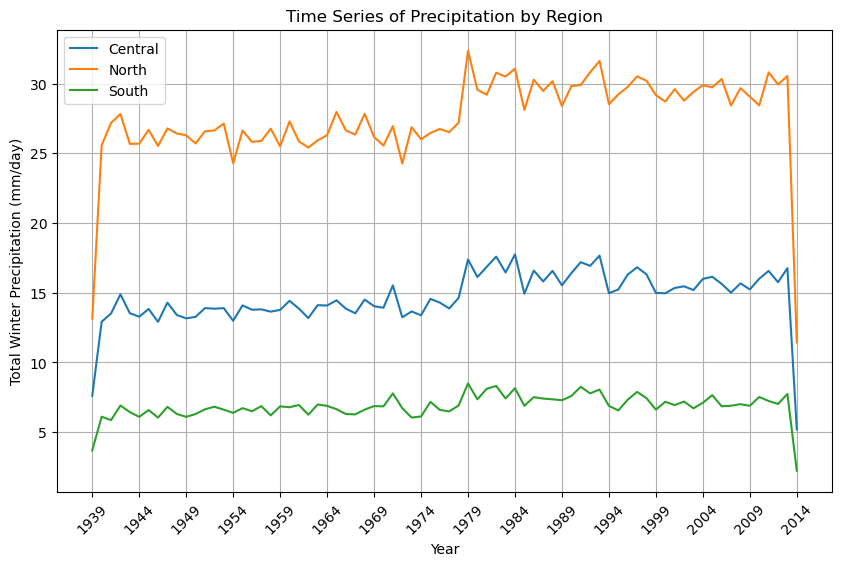

In [17]:
aggregated_data = dataframes.groupby(['year', 'region'])['PRECT'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

for region, data in aggregated_data.groupby('region'):
    plt.plot(data['year'], data['PRECT'], label=region)

plt.xlabel('Year')
plt.ylabel('Total Winter Precipitation (mm/day)')
plt.title('Time Series of Precipitation by Region')

x_ticks = data['year'][::5]
plt.xticks(ticks=x_ticks, rotation=45)

plt.legend()
plt.grid(True)

plt.show()